In [1149]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from os.path import join
import re
from collections import defaultdict

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Path to save plots to
filepath='/Users/ron/Code/master_thesis/report/LaTeX/img'

results_path = '/Users/ron/Code/master_thesis/results'

# CSVs
depth4_19 = 'stats_2023-11-24 03:51:18.452267'
depth4_inference_all_after_training_on_19 = 'stats_2023-11-30 11:14:48.912478'

depth4_29 = 'stats_2023-12-01 17:07:39.195518'
depth4_inference_all_after_training_on_29 = 'stats_2023-12-04 19:37:08.204531'

depth3_trained_on_4_tasks = 'stats_2023-11-29 11:24:58.566967'
depth3_trained_on_4_tasks_inference_37_tasks = 'stats_2023-11-29 13:24:37.473425'
depth3_inference_all_trained_on_4_tasks = 'stats_2023-11-29 13:38:47.483420'

depth3_trained_on_48_tasks_random_seed_1704 = 'depth_3_48_tasks2023-12-07 22:24:45'
depth3_trained_on_48_tasks_random_seed_1704_inference = 'depth_3_48_tasks2023-12-07 22:24:45_inference'

depth3_trained_on_48_tasks_random_seed_42 = 'depth_3_48_tasks2023-12-07 22:41:39'
depth3_trained_on_48_tasks_random_seed_42_inference = 'depth_3_48_tasks2023-12-07 22:41:392023-12-13 00:00:12_inference'

In [1129]:
# Train Data
filename_train = depth4_29
train_data = pd.read_csv(join(results_path, f'{filename_train}.csv'))
train_data = train_data[train_data['Mode'] != 'inference']

train_data = train_data.sort_values('Task Name')

if filename_train is depth4_29:
    depth4_19_data = pd.read_csv(join(results_path, f'{depth4_19}.csv'))
    depth4_19_data = depth4_19_data[depth4_19_data['Mode'] != 'inference']
    depth4_19_train_tasks = depth4_19_data['Task Name'].unique()
    train_tasks = list(depth4_19_train_tasks) + list(train_data['Task Name'].unique())

    depth4_19_solved_tasks = depth4_19_data[depth4_19_data['Solved'] == True]['Task Name'].unique()
    unique_solved_train = list(depth4_19_solved_tasks) + list(train_data[train_data['Solved'] == True]['Task Name'].unique())
    unique_solved_train = list(set(unique_solved_train))
else:
    train_tasks = train_data['Task Name'].unique()
    unique_solved_train = train_data[train_data['Solved'] == True]['Task Name'].unique()

print(f'Trained on {len(train_tasks)} unique tasks:')
# for t in train_tasks:
#     print(f'\t{t}')

print(f'solved {len(unique_solved_train)} unique tasks.')
for t in unique_solved_train:
    print(f'\t{t}')

Trained on 29 unique tasks:
solved 15 unique tasks.
	pow-k with k=4
	prepend-k with k=1
	keep-mod-k with k=4
	add-k with k=3
	caesar-cipher-k-modulo-n with k=5 and n=2
	slice-k-n with k=5 and n=1
	keep eq 2
	take-k with k=1
	caesar-cipher-k-modulo-n with k=1 and n=2
	modulo-k with k=3
	keep eq 0
	slice-k-n with k=1 and n=1
	add-k with k=5
	append-k with k=3
	keep-mod-k with k=3


In [1131]:
# Inference Data
filename_inference = depth4_inference_all_after_training_on_29
inference_data = pd.read_csv(join(results_path, f'{filename_inference}.csv'))

inference_tasks = inference_data['Task Name'].unique()
print(f'Inference on {len(inference_tasks)} unique tasks:')

unique_solved_inference = inference_data[inference_data['Solved'] == True]['Task Name'].unique()
print(f'solved {len(unique_solved_inference)} unique tasks.')
print(unique_solved_inference)

Inference on 145 unique tasks:
solved 33 unique tasks.
['add-k with k=1' 'append-k with k=0' 'pow-k with k=3' 'mult-k with k=0'
 'pow-k with k=4' 'prepend-k with k=2' 'prepend-k with k=4'
 'prepend-k with k=3' 'remove-index-k with k=1' 'append-k with k=2'
 'append-k with k=1' 'prepend-k with k=0' 'append-k with k=3'
 'prepend-k with k=1' 'slice-k-n with k=1 and n=1'
 'slice-k-n with k=3 and n=1' 'slice-k-n with k=2 and n=1' 'tail'
 'take-k with k=1' 'drop-k with k=1' 'keep squares' 'remove eq 0'
 'keep eq 0' 'add-k with k=3' 'remove gt 2' 'keep gt 0' 'keep eq 3'
 'append-k with k=5' 'remove gt 0' 'drop-k with k=2' 'keep-mod-k with k=2'
 'drop-k with k=3' 'modulo-k with k=1']


In [1132]:
solved_only_in_training = set(unique_solved_train) - set(unique_solved_inference)
print(f'{len(solved_only_in_training)} tasks were only solved in training: ')
print(solved_only_in_training)

solved_only_in_inference = set(unique_solved_inference) - set(unique_solved_train)
print(f'{len(solved_only_in_inference)} tasks were only solved in inference: ')

print(solved_only_in_inference)

8 tasks were only solved in training: 
{'keep-mod-k with k=4', 'keep eq 2', 'caesar-cipher-k-modulo-n with k=1 and n=2', 'modulo-k with k=3', 'slice-k-n with k=5 and n=1', 'add-k with k=5', 'caesar-cipher-k-modulo-n with k=5 and n=2', 'keep-mod-k with k=3'}
26 tasks were only solved in inference: 
{'append-k with k=1', 'mult-k with k=0', 'remove-index-k with k=1', 'prepend-k with k=2', 'prepend-k with k=0', 'keep squares', 'keep eq 3', 'keep-mod-k with k=2', 'remove gt 2', 'append-k with k=5', 'remove gt 0', 'append-k with k=0', 'prepend-k with k=3', 'drop-k with k=3', 'slice-k-n with k=2 and n=1', 'keep gt 0', 'drop-k with k=1', 'slice-k-n with k=3 and n=1', 'modulo-k with k=1', 'drop-k with k=2', 'remove eq 0', 'pow-k with k=3', 'add-k with k=1', 'prepend-k with k=4', 'tail', 'append-k with k=2'}


In [1133]:
task = 'prepend-k with k=1'
unique_task_solutions = inference_data[(inference_data['Solved'] == True) & (inference_data['Task Name'] == task)]['Program'].unique()
print(f'found {len(unique_task_solutions)} unique solution(s) to task {task}')
print(unique_task_solutions)

found 5 unique solution(s) to task prepend-k with k=1
['(car (map (cons 1) (cons var0 empty)))'
 '(if (empty? (cdr empty)) (cons (* 1 1) var0) (unfold 0 (eq? 0) (+ 4) (- 4)))'
 '(index (* (length empty) 1) (cons (cons 1 var0) (append var0 empty)))'
 '(cons 1 (car (cons var0 empty)))' '(cons 1 var0)']


In [1157]:
with open("task_names.txt", "r") as file:
    task_names = file.read().splitlines()

def extract_base_task_name(task_name):
    # Remove numerical values and additional spaces
    return re.sub(r'\d+', '', task_name).replace(' with ', '').strip()


# dictionary with (base name: list of tasks belonging to the group) pairs
task_groups = defaultdict(list)
for task_name in task_names:
    base_name = extract_base_task_name(task_name)
    task_groups[base_name].append(task_name)

train_basenames = {extract_base_task_name(task) for task in train_tasks}
inference_ood_solved = [task for task in unique_solved_inference if extract_base_task_name(task) not in train_basenames]
print(f'Solved {len(inference_ood_solved)} tasks from an unseen group')
print(inference_ood_solved)

Solved 7 tasks from an unseen group
['mult-k with k=0', 'tail', 'keep squares', 'remove eq 0', 'remove gt 2', 'keep gt 0', 'remove gt 0']
25


In [1134]:
def plot_program_variations_binary(data, filename, inference=False):
    # Calculate the number of unique programs per task
    unique_programs = data.groupby('Task Name')['Program'].nunique()

    # Determine if each task was solved at least once
    task_solved = data.groupby('Task Name')['Solved'].any()

    # Combine the unique programs count with the solved information
    combined_data = pd.concat([unique_programs, task_solved], axis=1)
    combined_data.columns = ['UniquePrograms', 'TaskSolved']

    # Calculate the average number of unique programs
    average_unique_programs = combined_data['UniquePrograms'].mean()

    # Set the figure size
    plt.figure(figsize=(12, 8))

    # Color mapping
    colors = combined_data['TaskSolved'].map({True: 'green', False: 'red'})

    # Plotting
    plot = combined_data['UniquePrograms'].plot(kind='bar', color=colors)

    # Plotting the average line
    plt.axhline(y=average_unique_programs, color='black', linestyle='--', label='Average')

    # Adding legend
    plt.legend(handles=[plt.Line2D([0], [0], color='green', lw=4, label='Solved'),
                        plt.Line2D([0], [0], color='red', lw=4, label='Not Solved'),
                        plt.Line2D([0], [0], color='black', lw=4, linestyle='--', label='Average')],
                        bbox_to_anchor=(0.8, 0.8)
                        )

    # Titles and labels
    plt.title('Variation in Programs per Task')
    plt.xlabel('Task Name')
    plt.ylabel('Number of Unique Programs')
    plt.xticks(rotation=90)
    if inference:
        # Coloring task name labels green if solved during training
        for label in plot.get_xticklabels():
            if label.get_text() in train_tasks:
                label.set_color('blue')
            if label.get_text() in unique_solved_train:
                label.set_color('green')
    
    # Layout adjustment and saving
    plt.tight_layout()
    plt.savefig(join(filepath, f'plot_program_variations_binary_{filename}.png'))
    plt.show()

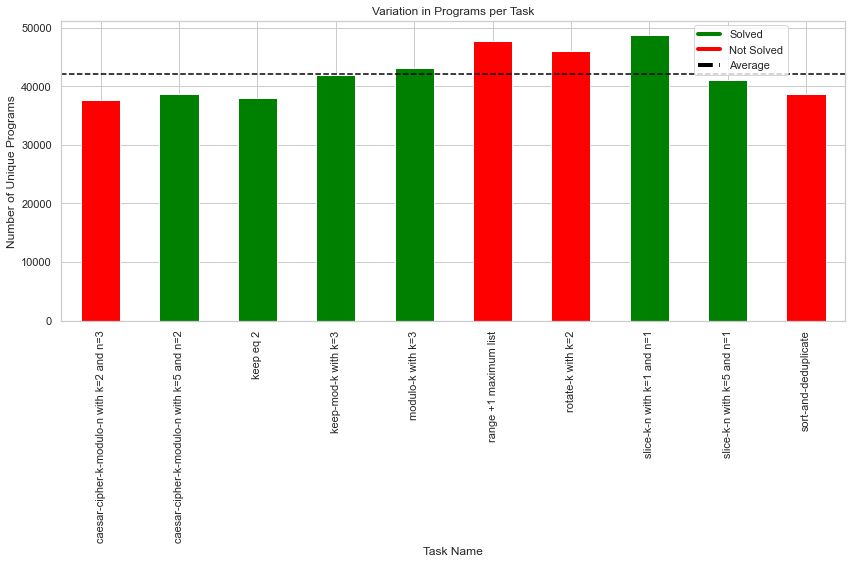

In [1135]:
plot_program_variations_binary(train_data, filename_train)

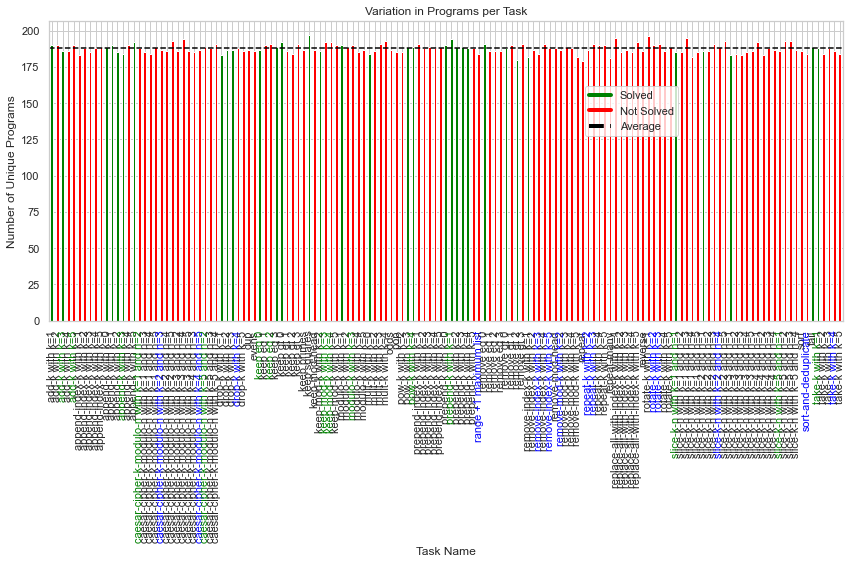

In [1136]:
plot_program_variations_binary(inference_data, filename_inference, inference=True)

In [1137]:
def plot_correct_frequency(data, filename, inference=False):

    # Filtering the dataset for instances where the reward is 10
    correct_solutions = data[data['Reward'] == 10]

    # Grouping the data by 'Task Name' and counting occurrences
    correct_solutions_count = correct_solutions.groupby('Task Name').size().reset_index(name='Correct Solutions Count')

    # Calculating the average number of correct solutions
    average_correct_solutions = correct_solutions_count['Correct Solutions Count'].mean()

    # Sorting the data for better visualization
    correct_solutions_count_sorted = correct_solutions_count.sort_values(by='Correct Solutions Count', ascending=False)

    colors = ['green' if task in unique_solved_train else 'purple' for task in correct_solutions_count['Task Name']]
    
    # Creating a bar

    # Creating a bar plot
    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(data=correct_solutions_count, x='Correct Solutions Count', y='Task Name', palette=colors if inference else 'magma')
    
    # Plotting the average line
    plt.axvline(x=average_correct_solutions, color='black', linestyle='--', label='Average Correct Solutions')

    # Plotting the average line
    plt.title('Number of Times Each Task was Correctly Solved')
    plt.xlabel('Correct Solutions Count')
    plt.ylabel('Task Name')
    if inference:
        # Coloring task name labels green if solved during training
        for label in barplot.get_yticklabels():
            if label.get_text() in unique_solved_train:
                label.set_color('green')
    plt.tight_layout()
    plt.savefig(join(filepath, f'plot_correct_frequency_{filename}.png'))
    # Showing the plot
    plt.show()


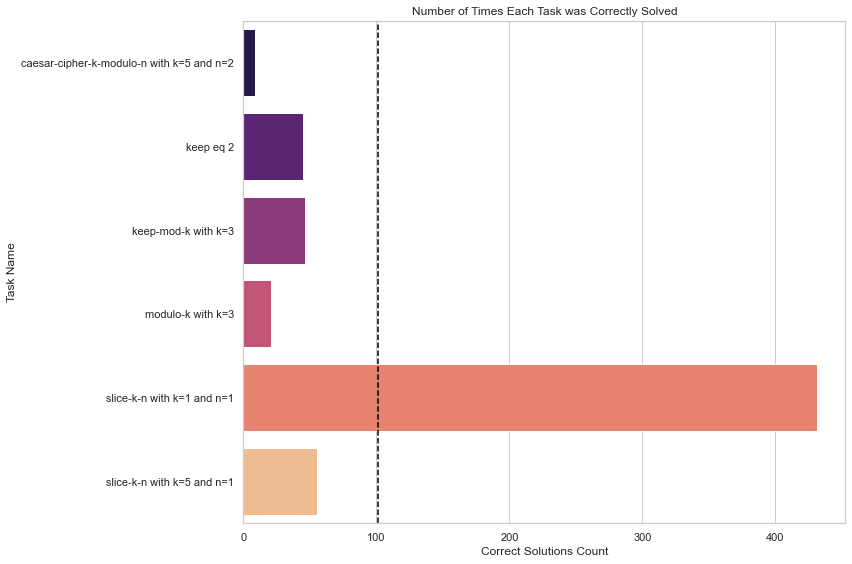

In [1138]:
plot_correct_frequency(train_data, filename_train)

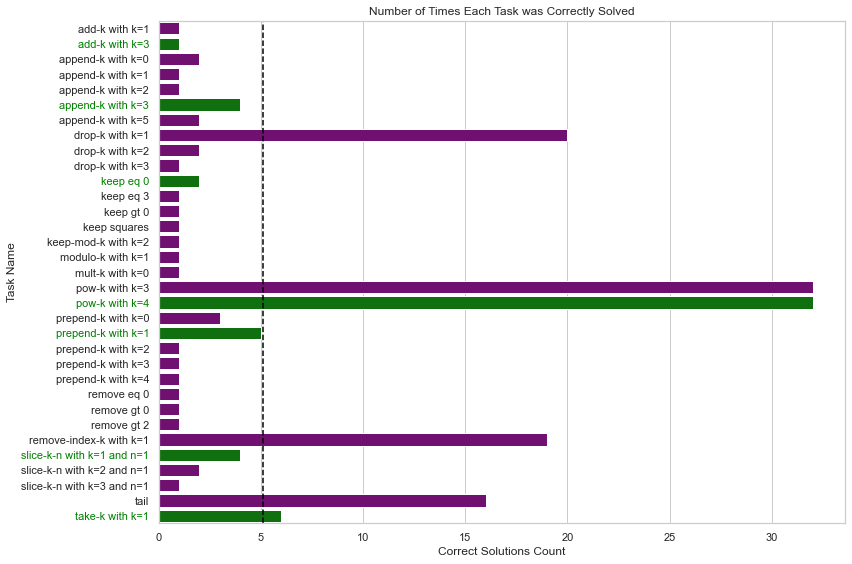

In [1139]:
plot_correct_frequency(inference_data, filename_inference, inference=True)

In [1140]:

def plot_solution_variations(data, filename, inference=False):
    # Filtering the data to include only the tasks that were solved
    solved_data = data[data['Solved'] == True]

    # Grouping the data by 'Task Name' and counting unique programs for each solved task
    solved_data = solved_data.groupby('Task Name')['Program'].nunique().reset_index()
    # solved_data = solved_data.sort_values(by='Program', ascending=False)

    # Creating a bar plot
    plt.figure(figsize=(12, 8))
    colors = ['green' if task in unique_solved_train else 'purple' for task in solved_data['Task Name']]
    barplot = sns.barplot(data=solved_data, x='Program', y='Task Name', palette=colors if inference else 'magma')

    # Setting y-axis to logarithmic scale
    plt.xscale('log')
    # plt.axvline(x=solved_data['Program'].mean(), color='black', linestyle='--', label='Average Correct Solutions')
    # Setting plot title and labels
    plt.title('Variation in Solutions per Task')
    plt.xlabel('Number of Unique Solutions (log scale)')
    plt.ylabel('Task Name')
    # plt.xticks(rotation=90)
    if inference:
        # Coloring task name labels green if solved during training
        for label in barplot.get_yticklabels():
            if label.get_text() in train_tasks:
                label.set_color('green')

        # Adding legend
        plt.legend(handles=[plt.Line2D([0], [0], color='green', lw=4, label='Solved in Training & Inference'),
                            plt.Line2D([0], [0], color='purple', lw=4, label='Solved in Inference')],
                            bbox_to_anchor=(0.9, 0.7))
    plt.tight_layout()

    # Save the plot
    plt.savefig(join(filepath, f'plot_solution_variations_{filename}.png'))

    # Showing the plot
    plt.show()

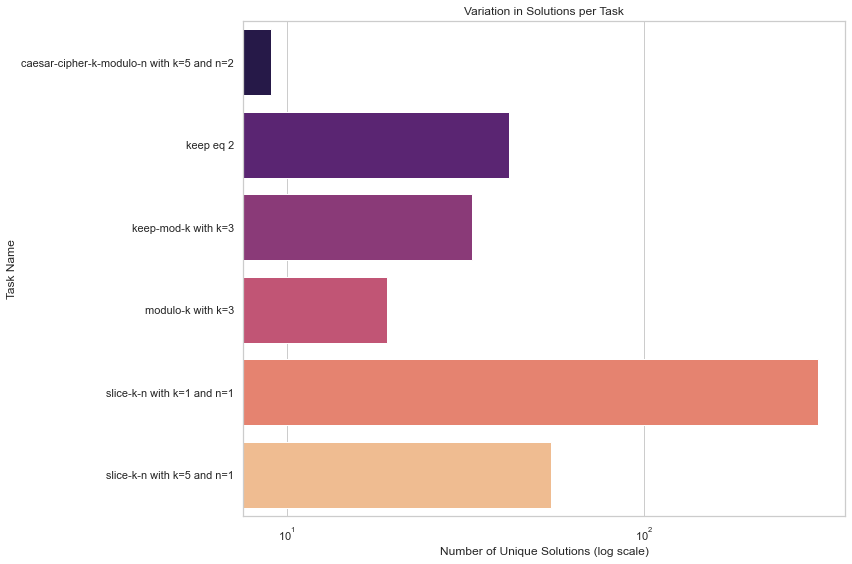

In [1141]:
plot_solution_variations(train_data, filename_train)

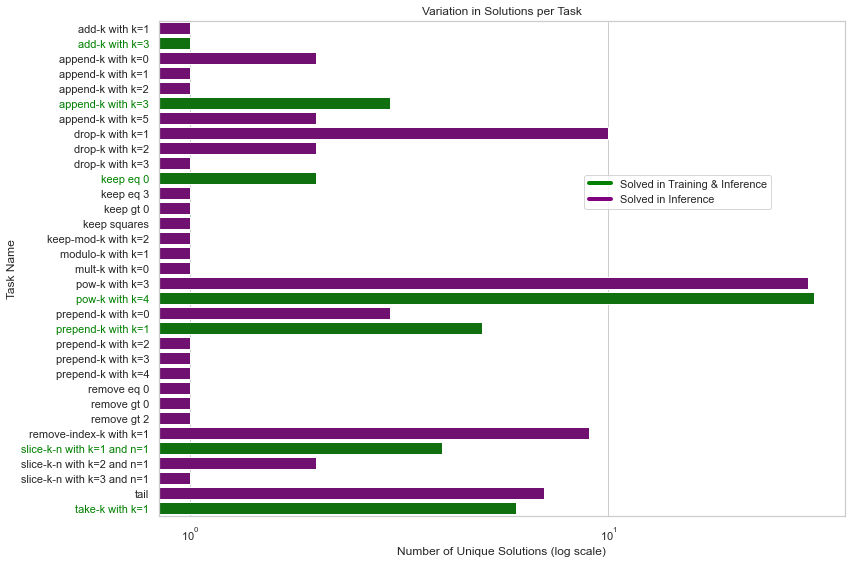

In [1142]:
plot_solution_variations(inference_data, filename_inference, inference=True)

In [1143]:
# Function to draw curly brackets
def draw_curly_bracket(x, y, width, height, orientation='up', ax=None):
    if ax is None:
        ax = plt.gca()
    if orientation == 'up':
        left_arc = patches.Arc((x, y), width, height, theta1=0, theta2=180)
        right_arc = patches.Arc((x + width, y), width, height, theta1=180, theta2=360)
    else:
        left_arc = patches.Arc((x, y), width, height, theta1=180, theta2=360)
        right_arc = patches.Arc((x + width, y), width, height, theta1=0, theta2=180)
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)

def plot_em_cycles(train_data, filename):
    
    # First, determine the total number of steps in each mode across all epochs
    total_e_steps = train_data[(train_data['Mode'] == 'e-step')]['Steps'].max() + 1  # Adding 1 because 'Steps' starts from 0
    total_m_steps = train_data[(train_data['Mode'] == 'm-step')]['Steps'].max() + 1
    total_steps_per_epoch = total_e_steps + total_m_steps

    # Now, create a new column 'Total Steps' that will accumulate steps across epochs and modes
    train_data['Total Steps'] = train_data['Epoch'] * (total_e_steps + total_m_steps) + \
                        train_data['Steps'] + \
                        np.where(train_data['Mode'] == 'm-step', total_e_steps, 0)

    # We are only analysing training data here, so this is just an assertion
    train_data = train_data[train_data['Mode'] != 'inference']

    # Now filter out tasks that have never been solved
    solved_tasks = train_data[train_data['Solved'] == True]['Task Name'].unique()
    filtered_data = train_data[train_data['Task Name'].isin(solved_tasks)]

    # Group and count solved instances, then calculate the cumulative sum
    solved_frequency = filtered_data.groupby(['Task Name', 'Epoch', 'Mode', 'Total Steps']).agg({'Solved': 'sum'}).reset_index()

    solved_frequency['Cumulative Solved'] = solved_frequency.groupby(['Task Name', 'Epoch', 'Mode'])['Solved'].cumsum()
    # Calculate the averages for each total step
    average_solved = solved_frequency.groupby('Total Steps')['Cumulative Solved'].mean().reset_index()

    # Plotting the existing lines for each task
    plt.figure(figsize=(20, 10))
    # for task in solved_tasks:
    #     task_data = solved_frequency[solved_frequency['Task Name'] == task]
    #     plt.plot(task_data['Total Steps'], task_data['Cumulative Solved'], label=task, alpha=0.3)



    # Draw curly brackets for each epoch
    for epoch in range(5):
        start_step = epoch * total_steps_per_epoch
        end_step = (epoch + 1) * total_steps_per_epoch
        middle_step = (start_step + end_step) / 2
        draw_curly_bracket(start_step, -0.05 * max(average_solved['Cumulative Solved']), total_steps_per_epoch / 2, 0.02 * max(average_solved['Cumulative Solved']), orientation='down')
        plt.text(middle_step, -0.1 * max(average_solved['Cumulative Solved']), f'Epoch {epoch + 1}', horizontalalignment='center', fontsize=16)


    # Plotting the average line
    plt.plot(average_solved['Total Steps'], average_solved['Cumulative Solved'], label='Average Cumulative Solutions', color='black', linewidth=2, linestyle='--')


    # Get the total steps for all epochs and set the x-ticks
    num_epochs = int(solved_frequency['Epoch'].max() + 1)
    total_steps = total_steps_per_epoch * num_epochs

    # Set the x-ticks to show e-step and m-step intervals
    plt.xticks(np.arange(0, total_steps, total_steps_per_epoch//2), np.arange(0, total_steps, total_steps_per_epoch//2), rotation=90)


    # Fill the background color for e-step and m-step intervals
    for epoch in range(num_epochs):
        start_e_step = epoch * total_steps_per_epoch
        end_e_step = start_e_step + total_e_steps
        start_m_step = end_e_step
        end_m_step = start_m_step + total_m_steps

        alpha = 0.1 + (epoch * 0.1)  # Adjust alpha for varying shades
        plt.axvspan(start_e_step, end_e_step, color='blue', alpha=alpha, lw=0)
        plt.axvspan(start_m_step, end_m_step, color='darkviolet', alpha=alpha, lw=0)

    # Ensure the plot includes the last m-step
    plt.xlim(0, total_steps)

    # Adjusting plot features for clarity
    plt.title('Cumulative Frequency of Solved Tasks Over E-Step and M-Step Cycles', fontsize=24)
    plt.xlabel('Epoch-Mode-Step', fontsize=20)
    plt.ylabel('Cumulative Solved Frequency', fontsize=20)

    # Increase the font size of the ticks
    plt.xticks(fontsize=18, rotation=90)  # Increase x-axis ticks font size
    plt.yticks(fontsize=18)  # Increase y-axis ticks font size

    # Create dummy lines for the legend
    e_step_line = mlines.Line2D([], [], color='blue', alpha=0.4, linewidth=10, label='E-Step')
    m_step_line = mlines.Line2D([], [], color='darkviolet', alpha=0.4, linewidth=10, label='M-Step')

    # Update the legend
    plt.legend(handles=[e_step_line, m_step_line, *plt.gca().get_lines()], loc='upper left', fontsize=18)
    plt.tight_layout()
    plt.savefig(join(filepath, f'em_cycles_{filename}.png'))

    # Show the plot
    plt.show()

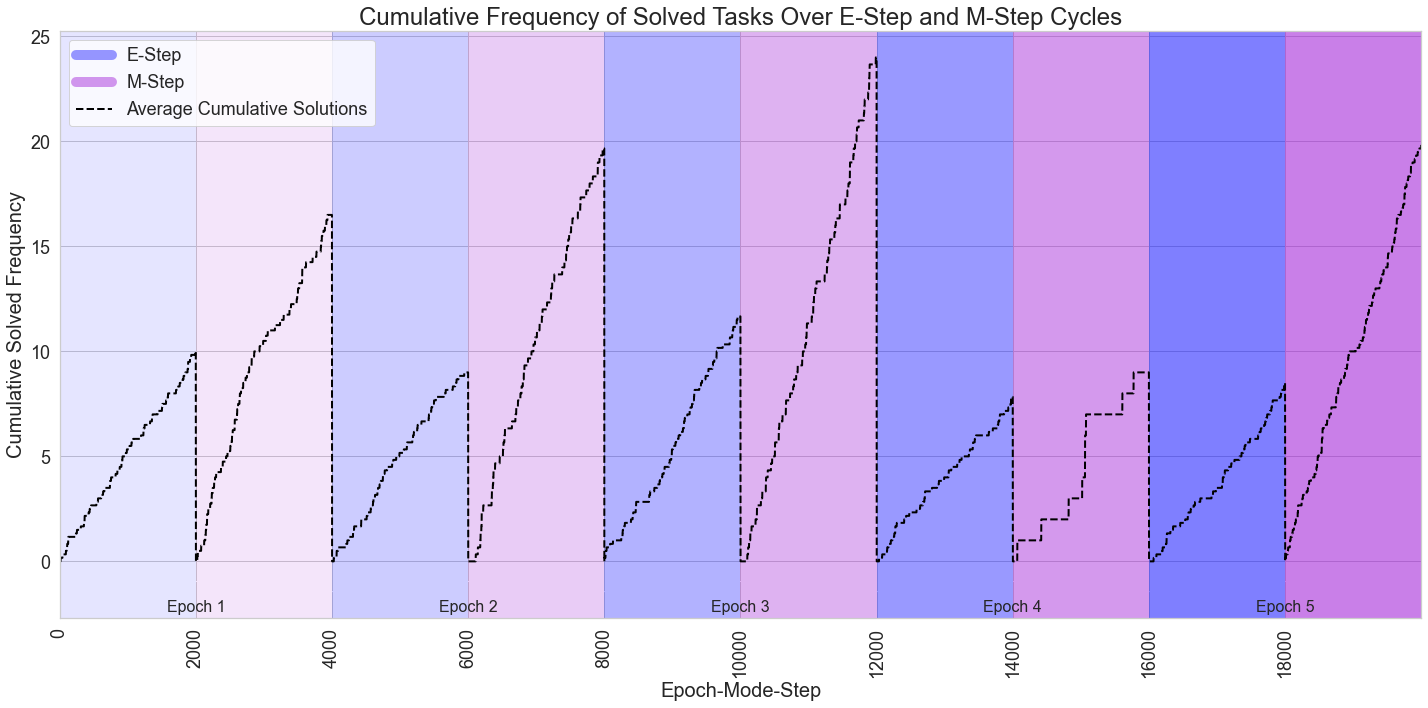

In [1144]:
plot_em_cycles(train_data, filename_train)

In [1145]:
def plot_min_step_for_solution(data, filename):

    # Filtering the data to include only the tasks that were solved
    solved_tasks = data[data['Solved'] == True]

    # Grouping the data by 'Task Name' and finding the minimum number of steps for each solved task
    steps_per_task = solved_tasks.groupby('Task Name')['Steps'].min().reset_index()

    # Sorting the data for better visualization
    steps_per_task_sorted = steps_per_task.sort_values(by='Steps')

    colors = ['green' if task in unique_solved_train else 'purple' for task in steps_per_task_sorted['Task Name']]

    # Creating a bar plot to show the number of steps for each solved task
    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(data=steps_per_task_sorted, x='Steps', y='Task Name', palette=colors)
    
    # Plotting the average line
    plt.axvline(x=steps_per_task_sorted['Steps'].mean(), color='black', linestyle='--', label='Average Correct Solutions')

    # Coloring task name labels blue if solved during training
    for label in barplot.get_yticklabels():
        if label.get_text() in unique_solved_train:
            label.set_color('green')

    # Adding legend
    plt.legend(handles=[plt.Line2D([0], [0], color='green', lw=4, label='Solved in Training & Inference'),
                        plt.Line2D([0], [0], color='purple', lw=4, label='Solved in Inference'),
                        plt.Line2D([0], [0], color='black', lw=4, linestyle='--', label='Average')],
                        bbox_to_anchor=(0.9, 0.7))
    
    
    plt.title('Minimum Steps Required to Solve Each Task')
    plt.xlabel('Steps')
    plt.ylabel('Task Name')
    plt.tight_layout()

    # Optionally save the plot
    plt.savefig(join(filepath, f'plot_min_step_for_solution_{filename}.png'))

    # Showing the plot
    plt.show()

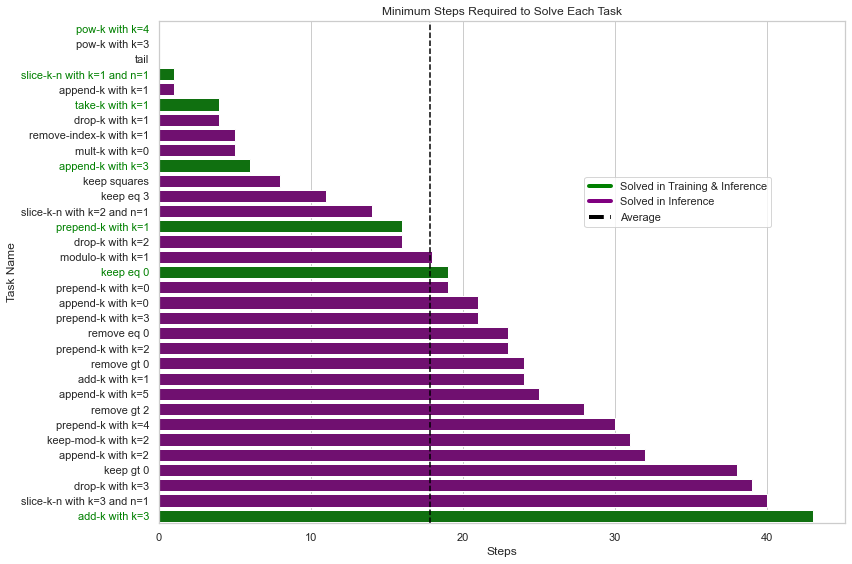

In [1146]:
plot_min_step_for_solution(inference_data, filename_inference)

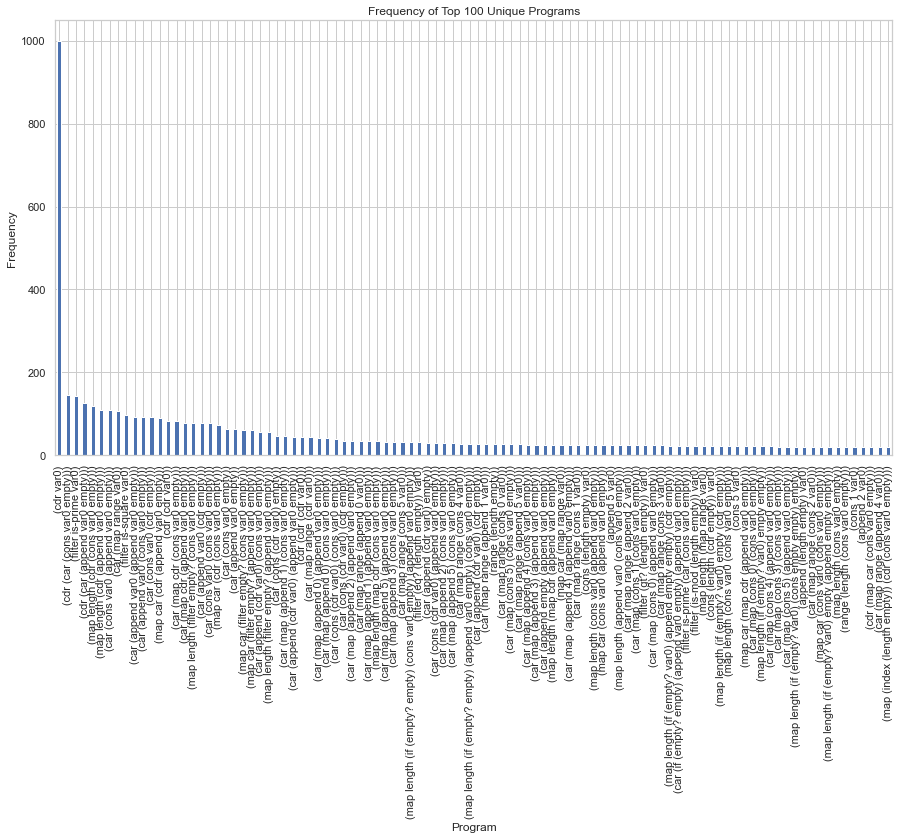

In [1147]:
# Calculate the frequency of each unique program in the dataset and select the top n
top_n = 100
program_frequency_top_n = inference_data['Program'].value_counts().head(top_n)

# Create the plot for the top N programs
plt.figure(figsize=(15, 8))  # Adjusting the figure size for better readability
program_frequency_top_n.plot(kind='bar')
plt.title(f'Frequency of Top {top_n} Unique Programs')
plt.xlabel('Program')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotating the x-axis labels for better visibility
plt.show()